# FFT and Reconstruction

A first idea for machine learning on this dataset is to try to use fast Fourier transorm to make useful features from time series. That's why we will first examine FFT on these time series.

Fourier showed that any periodic signal s(t) can be written as a sum of sine waves with various amplitudies, frequencies and phases [2]:

<img src="pictures/fft.png">

Results of this are amplitudes and phase shifts for frequency range from 0 to half the sampling frequency and it is covered by (N/2)+1 points where N is the size of the window i.e. number of samples. From Nyquist's theorem we know that the largest frequency component in the original signal must be half the sampling frequency. So, from a 2000 point FFT of signals sampled at 2000Hz we get 1001 unique spectral points covering the range 0 to 1000Hz.



In [1]:
import h5py                                                 #importing the h5 package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors                                #ploting with colors
import scipy.fftpack                                         #fourier tranformation
from collections import OrderedDict

import matplotlib as mpl
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

C:\Users\Ehlimana\Anaconda3\envs\ZEMA\lib\site-packages\PyDynamic\identification\fit_filter.py:34: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 3.0. From then on you should only use the new module *model_estimation* instead.
  DeprecationWarning)


### Data import

In [10]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements  in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))


    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements  in time
    and 6291 represents number of cycles.


In [11]:
#noise - ovo zanemari 
sigma=input("Enter sigma value") #noise is normally distributed with mean = 0 and variance sigma
noiselist=[] 
for i in range(6291):
    noiselist.append((np.random.normal(0, float(sigma)**2, 2000))) #creating list of 6291 elements with 2000 subelements
print("Dimensions of sensor dataframe:",sensorADC[0].shape) #to check dimensions of the dataframe for the first sensor
#turn the noiselist into dataframe
noise_frame = pd.DataFrame(noiselist) 
#print the first five rows of noise_frame to check dimensions
noise_frame.head()
#check the dimensions of noise_frame
print("Dimensions of noise array before transposing",noise_frame.shape)
#turn the data frame into 2-D array, so that it can be summed with sensorADC values
noisearray=noise_frame.values
#transpose the noise array
noisearray=noisearray.T
print("Dimensions of noise array after transposing", noisearray.shape)
sensoradc=sensorADC[0][:][:].values
sensor_noise=noisearray+sensoradc
print("Data of the first sensor, including noise",sensor_noise)




Enter sigma value0.0001
Dimensions of sensor dataframe: (2000, 6291)
Dimensions of noise array before transposing (6291, 2000)
Dimensions of noise array after transposing (2000, 6291)
Data of the first sensor, including noise [[ -39063.94231506   26382.8663802   111982.57630033 ...  106893.56694731
    14997.51318893 -120743.44167087]
 [  10194.7020446    46487.9916185    55068.14606452 ...  186312.48648486
   170208.82667603  157749.78903136]
 [  66179.32290934 -117858.50229111   12318.40003405 ... -279420.32878665
  -243057.1755882    87691.02827229]
 ...
 [ -22422.04902769 -135552.0229535  -150563.58271318 ... -529109.90835792
   683435.01393096 -209646.6256149 ]
 [-142152.85318954  -51139.30279162 -176505.35867422 ...  513334.34077179
   -98201.96350442 -503609.5442671 ]
 [-370131.30534626  -93251.46144852  -94345.040545   ... -330424.25875394
  -457915.47156912  428397.6401947 ]]


### Converting into SI units 

In [6]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]

In [7]:
sensor=sensorADC

###### If you have problems with previous step, you can skip conversion into SI units by runing next cell.

*One cycle of microphone sensor will be analysed with `FFT`.*

In [8]:
# 0 represents sensor number (microphone)
# 3000 represents cycle number from microphone
df=sensor[0][3000] 
len(df)

2000

Time axis is formed based on informations about data (`0_Data_Import_and_Visualisation.ipynb`). Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

After fast Fourier transform, this signal can be represented in the frequency domain. (**Amplitude-Frequency** plot) 

In [26]:
time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=2000                                                     # sampling points

x = np.true_divide(df.index, n_of_sampling_pts)                            # time values
freq = np.fft.rfftfreq(n_of_sampling_pts, float(time)/n_of_sampling_pts)   # frequency axis
amp = np.fft.rfft(df)      
print(amp)


Float64Index([   0.0, 0.0005,  0.001, 0.0015,  0.002, 0.0025,  0.003, 0.0035,
               0.004, 0.0045,
              ...
               0.995, 0.9955,  0.996, 0.9965,  0.997, 0.9975,  0.998, 0.9985,
               0.999, 0.9995],
             dtype='float64', length=2000)
[50700770.35451491       +0.j          9405656.79851278+13253100.69031763j
 29768952.88083674-13713438.16298695j ...
  -675116.63024967 -2453830.95115141j -2113924.18009246 -8873907.54909761j
  -456424.58122909       +0.j        ]


Text(0, 0.5, 'Amplitude (Pa)')

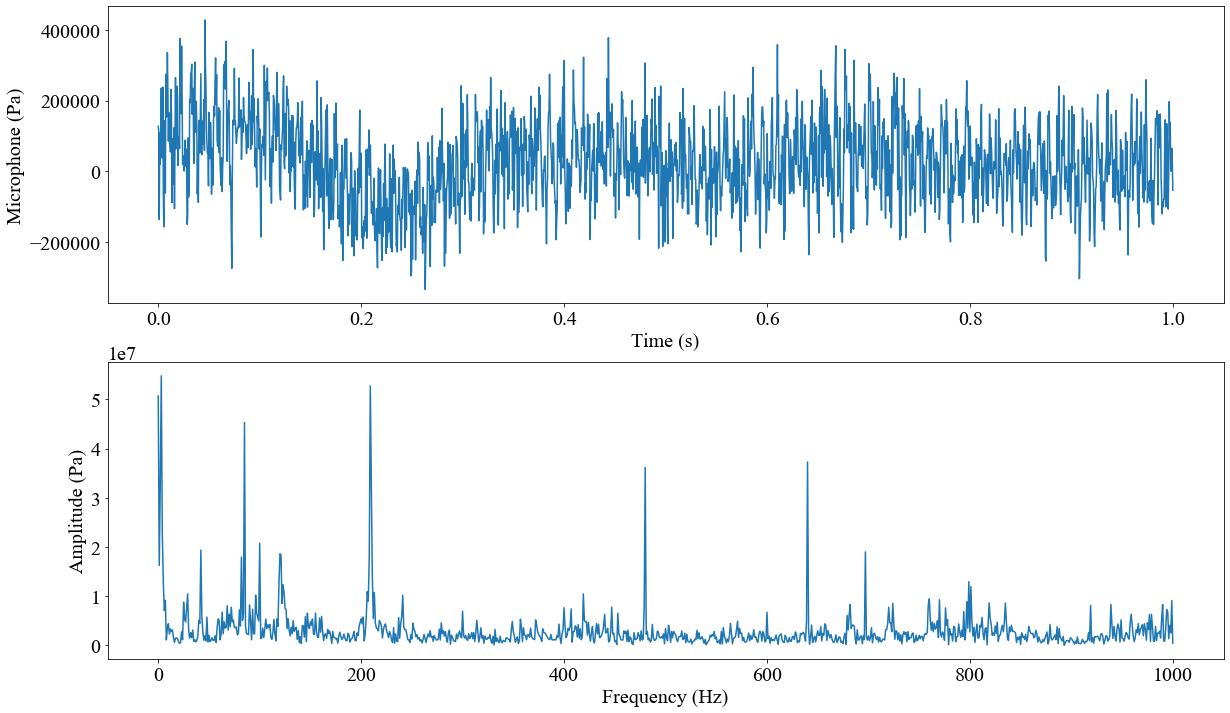

In [13]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")

plt.subplot(212)
plt.plot(freq,np.abs(amp))
plt.xlabel("Frequency (Hz)")  
plt.ylabel("Amplitude (Pa)")  

Because of idea to use 10% of these amplitudes for machine learning workflow, which should be enough to reconstruct the signal and make prediction, reconstruction using 10% highest amplitudes will be shown here.

Amplitudes are sorted by their absolute values from highest to lowest.

In [14]:
coeffs = dict(zip(freq, amp))

# take top N % of coefficients  !!!! This can be changed !!!!
N=10

# taking top N % aplitudes and sorting them by value, t[1] means sorting by second column i.e. by values of dictionary
out = OrderedDict(sorted(coeffs.items(), key=lambda t: abs(t[1]), reverse=True)[:round((N/100.0)*len(freq))])  

sorted_amp=list(out.values())                  #transforming sorted dictionary to the list

Keeping only 10% choosen frequencies. 

In [15]:
treeshold_apsolute_amplitude=abs(sorted_amp[-1])      #choosing the treeshold amplitude

for key, value in coeffs.items():
        if abs(value) <= treeshold_apsolute_amplitude:
             coeffs[key]=0+0j
                
top_10=list(coeffs.values())

Another plot in frequency domain, will show which frequencies out of full spectrum are selected and why.

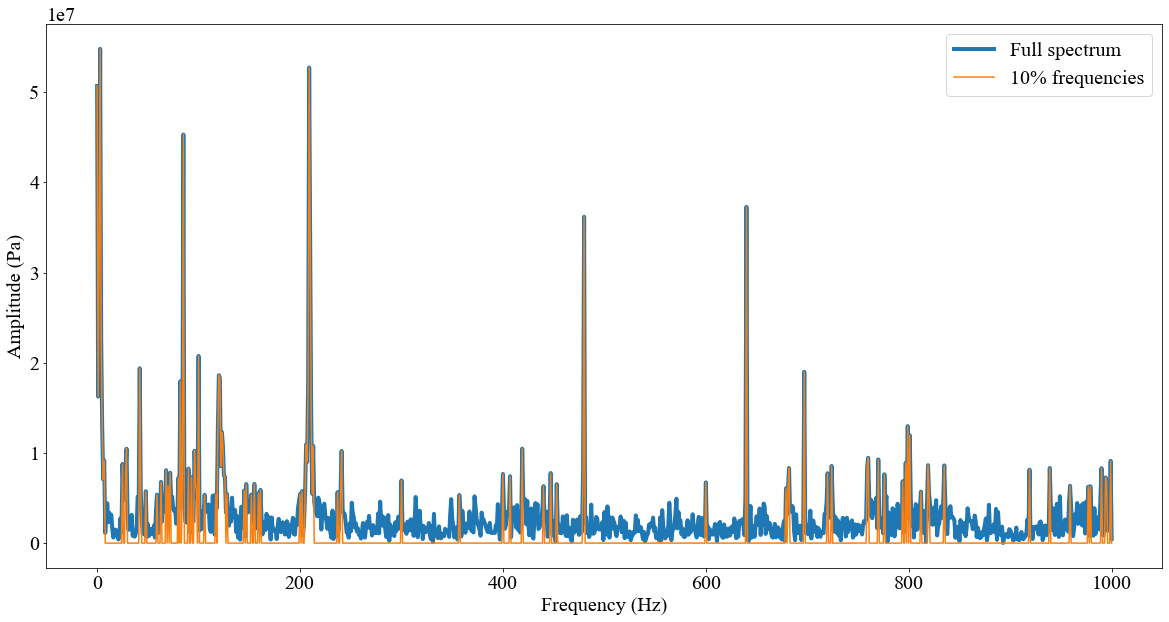

In [16]:
plt.plot(freq,np.abs(amp),zorder=1, linewidth=4,label='Full spectrum') 
plt.ylabel("Amplitude (Pa)") 

plt.plot(np.abs(top_10),zorder=2, label='10% frequencies')
plt.xlabel("Frequency (Hz)")
plt.legend()

Next plot shows sorted amplitudes, but without frequency labels.  

Text(0, 0.5, 'Amplitude (Pa)')

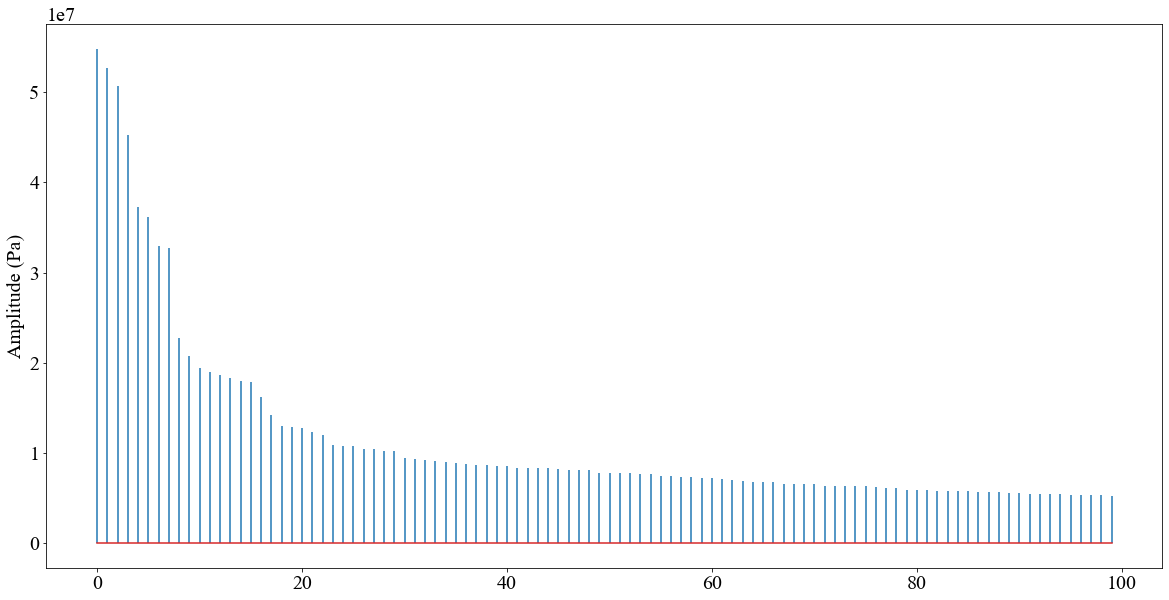

In [17]:
plt.stem(np.abs(sorted_amp), markerfmt=' ', use_line_collection=True)
plt.ylabel("Amplitude (Pa)") 

Reconstructing using inverse fast Fourier transform will give similar sensor signal, and that is why these frequencies and amplitudes are very good features for comparing different cycles.

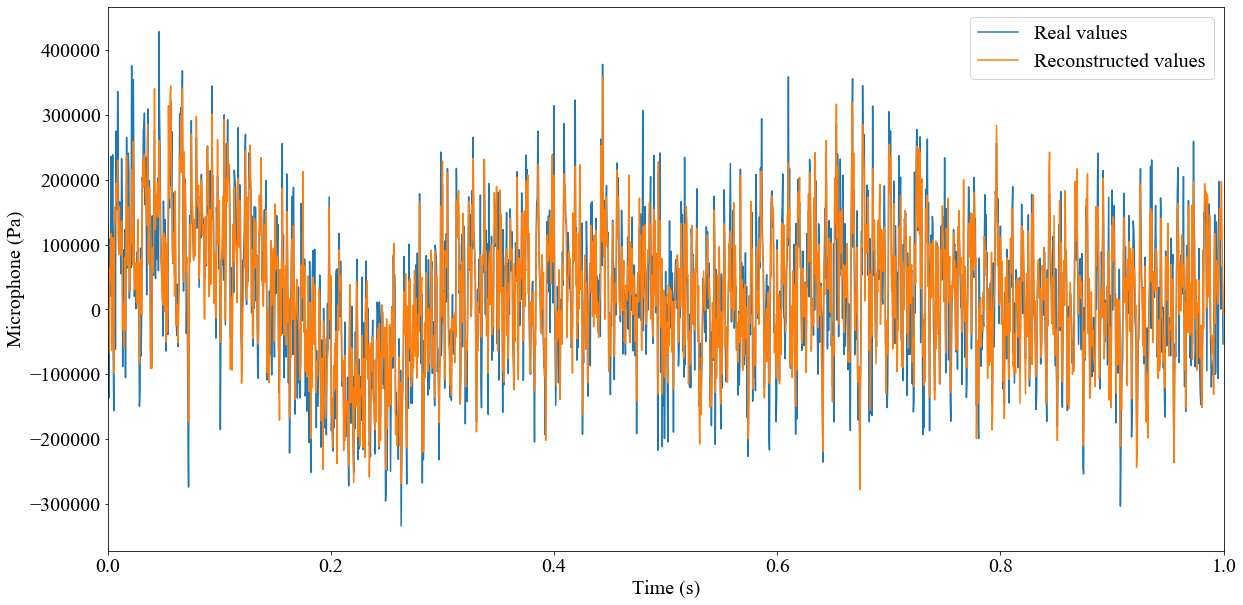

In [18]:
inverse_fft = np.fft.irfft(top_10)

plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.plot(x.values,inverse_fft, label="Reconstructed values")
plt.xlim(0,1)
plt.legend()


This procedure can be done for every sensor and every cycle of each sensor.

## Uncertainty propagation

In order to perform uncertainty evaluation,the PyDynamic software package will be used. This package contains several methods from signal processing and the chosen method for the propagation of uncertainities is discrete Fourier transform (DFT). To install the package, write `pip install PyDynamic` on your system’s command line.

Uncertainty propagation for 11 sensors and 6291 measurement cycles requires signifcant processing time. For this reason, uncertainty propagation is done for one cycle of one sensor. The time domain signal is x with associated squared uncertainty ux. The result of the DFT is the vector X of real and imaginary parts of the DFT applied to x and the associated uncertainty UX (covariance matrix associated with real and imaginary part of X). 
Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

*One cycle of microphone sensor will be analysed with `DFT`.*


In [27]:
import PyDynamic                                            #PyDynamic is necessary for the uncertainty evaluation
from PyDynamic.uncertainty.propagate_DFT import GUM_DFT
sigma=float(input("Assume standard deviation:"))
sensor_num = int(input("Enter the number of sensor (0-11):"))
cycle=int(input("Enter the cycle(0-6291):"))
ux=sigma**2


time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=2000                                                     # sampling points
time_steps=np.arange(0, time, float(time)/n_of_sampling_pts)               # timesteps for the period (0 - 1) s
X,UX=GUM_DFT(sensor[sensor_num][:][cycle],ux)
print("Vector X:",X)                                                       # vector of real and imaginary parts
print("Vector UX",UX)                                                      # covariance matrix of uncertainites
freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(2000, float(time)/n_of_sampling_pts) # frequency axis (array of length N//2 + 1 containing the sample frequencies)


Assume standard deviation:0.0001
Enter the number of sensor (0-11):0
Enter the cycle(0-6291):0
Vector X: [11767492.72655156  8502010.23648077  2909714.1972792  ...
  1105026.93846765  1370909.25535378        0.        ]
Vector UX [2.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.00000000e-05
 1.00000000e-05 1.04599705e-30]


Text(0.5, 0, 'frequency / Hz')

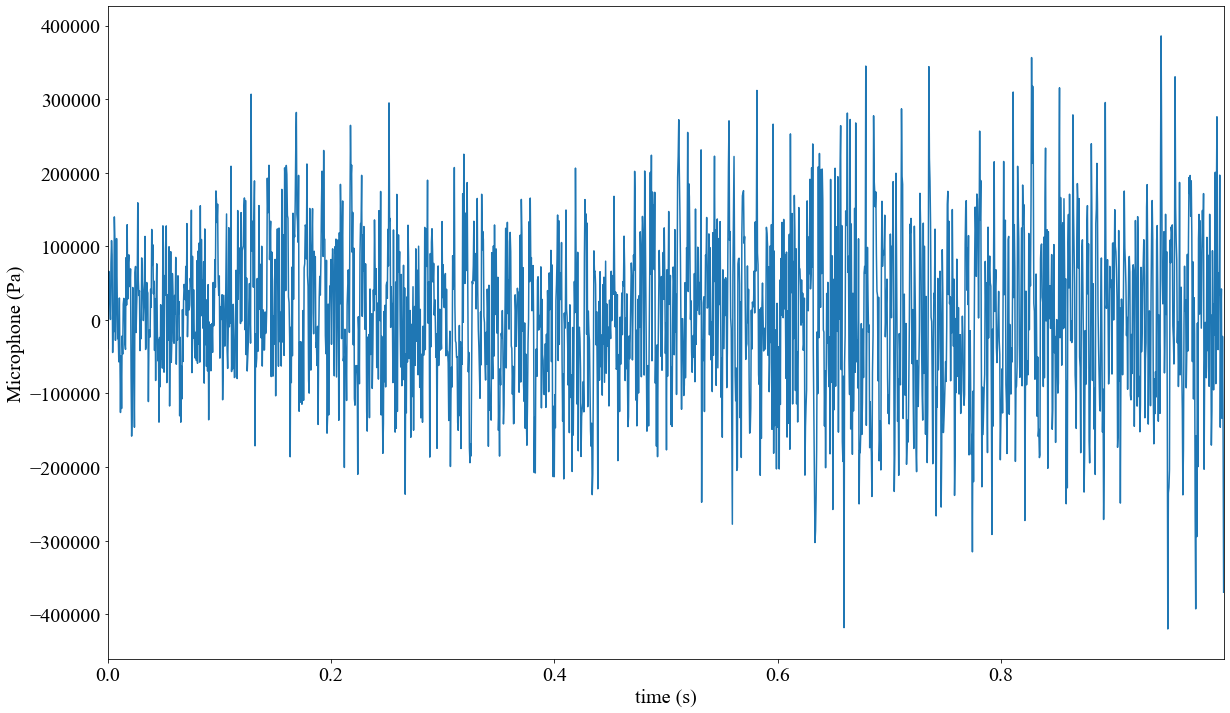

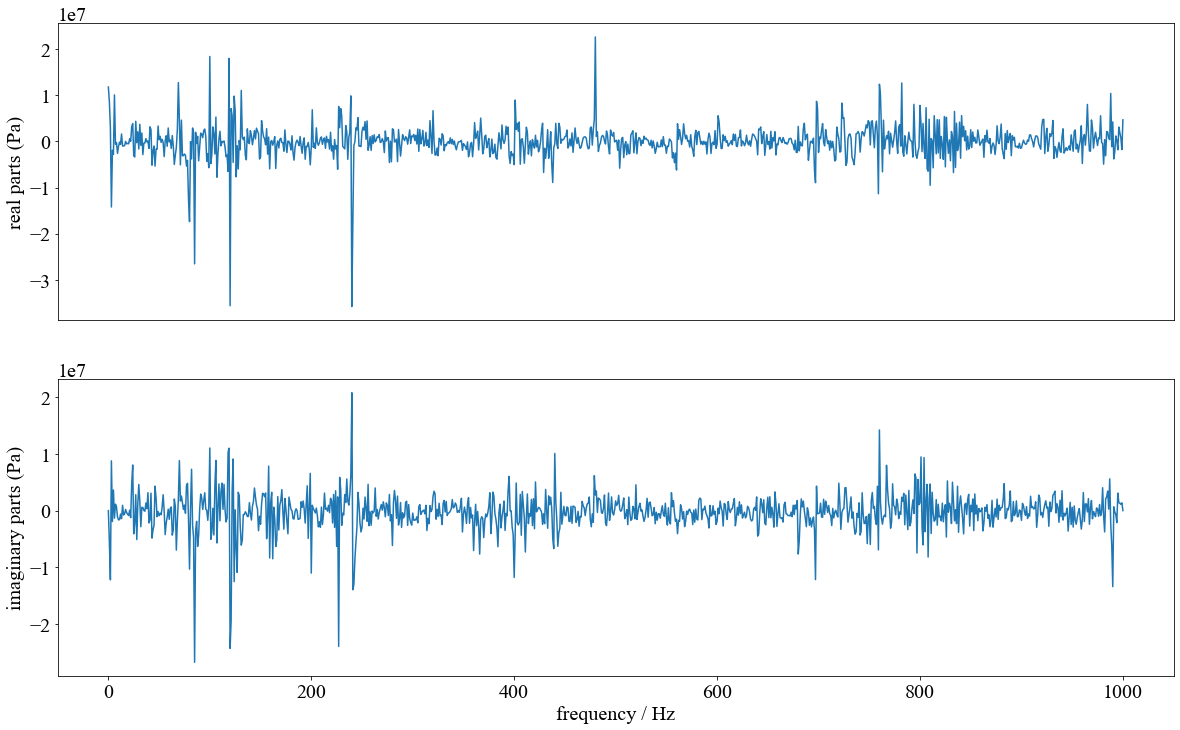

In [32]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))
plt.plot(time_steps, sensor[sensor_num][:][cycle])
plt.xlim(time_steps[0], time_steps[-1])
plt.xlabel("time (s)")
plt.ylabel("Microphone (Pa)")

plt.figure(figsize=(20,12))
plt.subplot(211)
plt.errorbar(freq, X[:len(freq)], np.sqrt(UX[:len(freq)]))
plt.ylabel("real parts (Pa)")
plt.xticks([])
plt.subplot(212)
plt.errorbar(freq, X[len(freq):], UX[len(freq):])
plt.ylabel("imaginary parts (Pa)")
plt.xlabel("frequency / Hz")



### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[4]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018

[5] https://pydynamic.readthedocs.io/en/master/Getting%20started.html#quick-examples

